https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/historical-volatility-hv/

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

df = df = pd.read_excel("Complete-dataset-FINAL.xlsx")
df['Year'] = pd.to_datetime(df["Year"], format='%Y')

cap = df.loc[df['Source (CAP/EurA1c)'] == 'CAP']
eur = df.loc[df['Source (CAP/EurA1c)'] == 'EURA1c']

In [88]:
cap_cv = cap[["Year", "Method name", "CV"]].groupby(["Method name", "Year"]).mean()
eur_cv = eur[["Year", "Method name", "CV"]].groupby(["Method name", "Year"]).mean()

# CAP

In [89]:
# CAP
df = cap_cv.copy()

methods = cap_cv.index.get_level_values(0).unique()

volatility = pd.DataFrame(columns=["Method", "Volatility", "Data points amount"])

minYears = 5

for method in methods:
    if len(df.loc[method]) < minYears:
        continue
    cvs = df.loc[method]
    variance = cvs.std(ddof=0)[0]
    volatility = pd.concat([volatility, pd.DataFrame({"Method": [method], "Volatility": [variance]})])

volatility.sort_values(by=["Volatility"], inplace=True)
volatility.reset_index(drop=True, inplace=True)
volatility.set_index("Method", inplace=True)

for method in methods:
    volatility.loc[method, "Data points amount"] = len(df.loc[method])

classes = []
count = 0
while count < len(volatility):
    classes.append(int(count/5) + 1)
    count += 1
volatility["Class"] = classes
volatility.dropna(inplace=True)
volatility["Volatility"] = volatility["Volatility"].astype(float)
volatility["Data points amount"] = volatility["Data points amount"].astype(int)

volatility.head(20)

,Volatility,Data points amount,Class
Method,,,
Sebia Capillarys 2 Flex Piercing,0.062766,5,1
Roche Diagnostics Cobas c513,0.079933,5,1
Bio-Rad D-100,0.111028,5,1
Tosoh G8 Auto HPLC,0.128977,13,1
Bio-Rad Variant II Turbo,0.150128,14,1
Siemens DCA Vantage,0.150552,13,2
Arkray Adams HA-8180 series,0.151002,6,2
Vitros 5.1 FS. 4600. 5600,0.163658,10,2
Roche Diagnostics Cobas c500 series,0.193355,9,2


<AxesSubplot:>

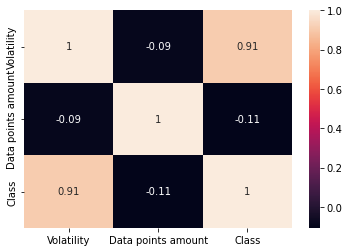

In [90]:
import seaborn as sns
sns.heatmap(volatility.corr(), annot=True)

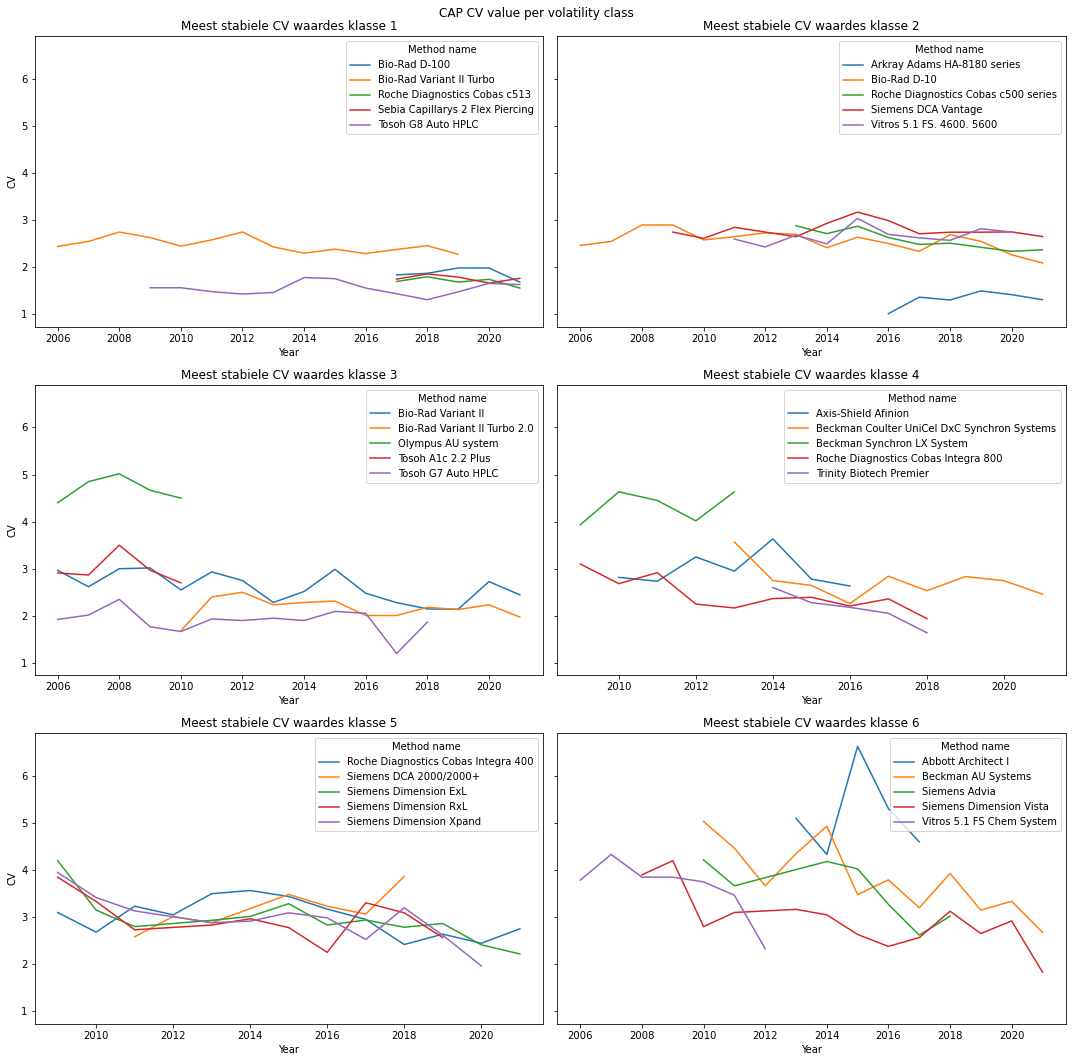

In [91]:
import numpy as np
from math import ceil, floor
df["Class"] = np.nan

for method in volatility.index:
    df.loc[method, "Class"] = volatility.loc[method, "Class"]

class_amount = int(df["Class"].max())

rows = ceil(class_amount / 5)
columns = ceil(class_amount / 2) - 1

fig, axes = plt.subplots(columns, rows, figsize=(15, 15), sharey=True, squeeze=False)

fig.suptitle("CAP CV value per volatility class")

for i in range(1, class_amount):
    selection = df.loc[df["Class"] == i]
    x = (i - 1) % rows
    y = floor((i - 1) / rows)
    axes[y, x].set_title(f"Meest stabiele CV waardes klasse {i}")
    sns.lineplot(ax=axes[y, x], data=selection, x="Year", y="CV", hue="Method name")
fig.tight_layout()
plt.show()

# EurA1c

In [92]:
df = eur_cv.copy()

methods = eur_cv.index.get_level_values(0).unique()

volatility = pd.DataFrame(columns=["Method", "Volatility", "Data points amount"])

for method in methods:
    if len(df.loc[method]) < 3:
        continue
    cvs = df.loc[method]
    variance = cvs.std(ddof=0)[0]
    volatility = pd.concat([volatility, pd.DataFrame({"Method": [method], "Volatility": [variance]})])

volatility.sort_values(by=["Volatility"], inplace=True)
volatility.reset_index(drop=True, inplace=True)
volatility.set_index("Method", inplace=True)

for method in methods:
    volatility.loc[method, "Data points amount"] = len(df.loc[method])

classes = []
count = 0
while count < len(volatility):
    classes.append(int(count/5) + 1)
    count += 1
volatility["Class"] = classes
volatility.dropna(inplace=True)
volatility["Volatility"] = volatility["Volatility"].astype(float)
volatility["Data points amount"] = volatility["Data points amount"].astype(int)

volatility.head(20)

,Volatility,Data points amount,Class
Method,,,
Bio-Rad not specified/other,0.108012,3,1
Tosoh not specified/other,0.131233,3,1
Roche Diagnostics,0.173606,3,1
Menarini (ARKRAY) not specified/other,0.251558,4,1
Tosoh G8 Auto HPLC,0.257196,5,1
Bio-Rad D-10,0.279106,5,2
Tosoh G11 Auto HPLC,0.330614,3,2
Alere Afinion,0.374700,5,2
Bio-Rad D-100,0.465994,5,2


<AxesSubplot:>

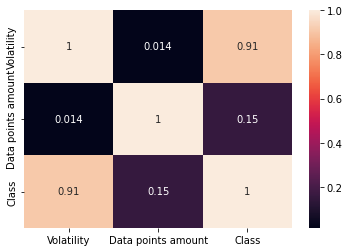

In [93]:
import seaborn as sns
sns.heatmap(volatility.corr(), annot=True)

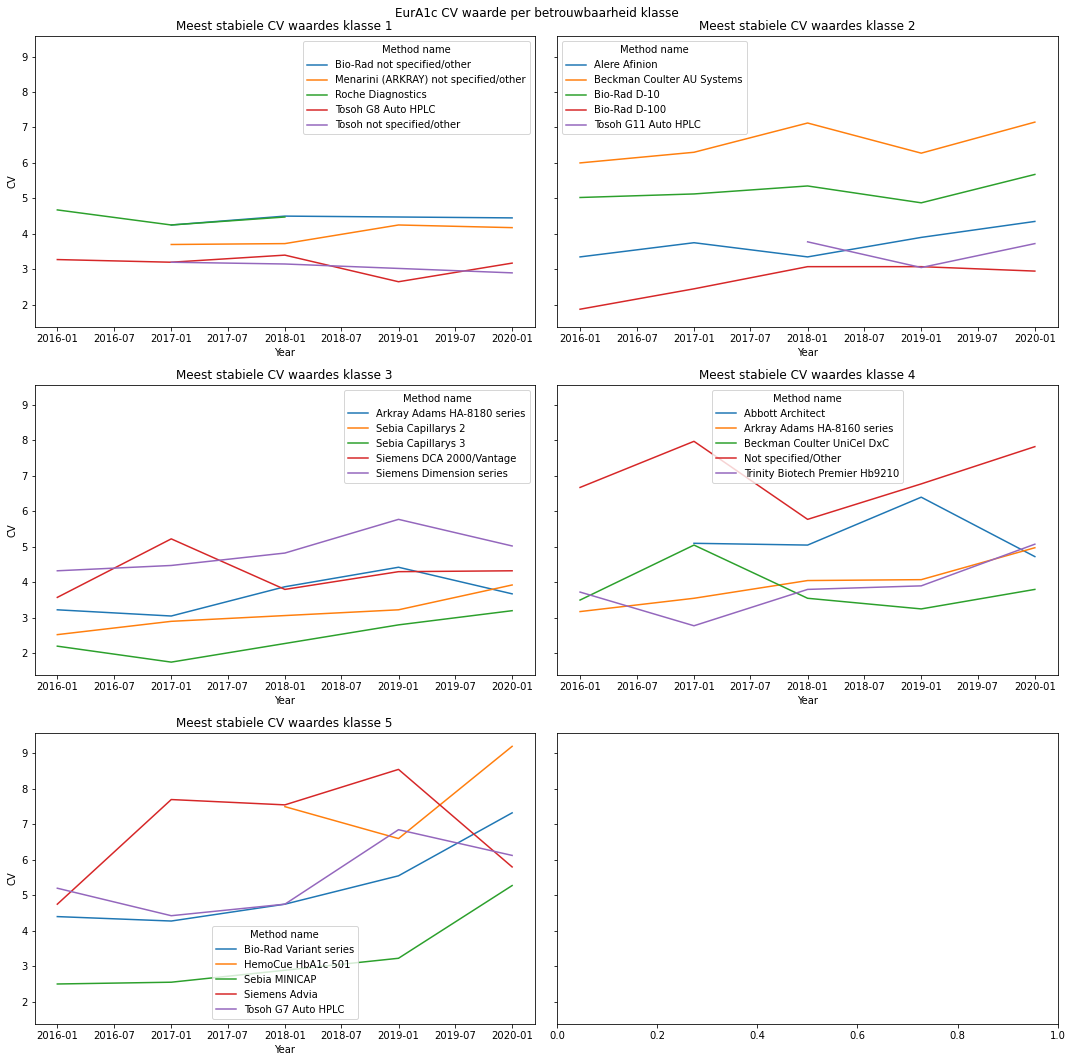

In [96]:
import numpy as np
from math import ceil, floor
df["Class"] = np.nan

for method in volatility.index:
    df.loc[method, "Class"] = volatility.loc[method, "Class"]

class_amount = int(df["Class"].max())

rows = ceil(class_amount / 5)
columns = ceil(class_amount / 2)

fig, axes = plt.subplots(columns, rows, figsize=(15, 15), sharey=True, squeeze=False)

fig.suptitle("EurA1c CV waarde per betrouwbaarheid klasse")

for i in range(1, class_amount):
    selection = df.loc[df["Class"] == i]
    x = (i - 1) % rows
    y = floor((i - 1) / rows)
    axes[y, x].set_title(f"Meest stabiele CV waardes klasse {i}")
    sns.lineplot(ax=axes[y, x], data=selection, x="Year", y="CV", hue="Method name")
fig.tight_layout()
plt.show()